Задача "Модератор Одноклассников"

Формулировка задания

В социальной сети Одноклассники есть платформа для разметки данных. На ней пользователям была дана задача выделить прямоугольником заданный объект на фотографии. По ответам людей нужно восстановить истинное положение объекта.

На входе вы получите краудсорсинговую разметку и данные в виде любимых всеми табличек, бейзлайн и тестовый сабмит с нулями. 

В ответ вы должны будете прислать просто файл (такой же, как и sample_submit) с вашими предсказаниями.

Предварительные результаты валидируются на 50% выборки. В день можно загружать не более 5 решений.

Для оценки решения будет использоваться метрика mIOU (mean intersection over union). Если еще не сталкивались с данной метрикой, то рекомендуем прочитать о ней [статью](https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/).

https://mlbootcamp.ru/round/21/tasks/

In [1]:
import os
import json
from tqdm import tqdm_notebook
import itertools
import time
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
matplotlib.rcParams['figure.figsize'] = (8, 8)
sns.set_style('whitegrid')

In [3]:
matplotlib.rcParams['figure.figsize'] = (8, 8)
matplotlib.rcParams['axes.facecolor']='white'
matplotlib.rcParams['axes.edgecolor']='black'
matplotlib.rcParams['xtick.color']='black'
matplotlib.rcParams['ytick.color']='black'
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=['black', "red", "blue", "limegreen", 'purple', 'yellow', 'orange', 'green'])
matplotlib.rcParams['axes.linewidth']=1.3
matplotlib.rcParams['text.color']='black'

Прописываем путь до папки с данными

In [10]:
FILE_PATH = '/Users/anton.andreytsev/competitions/data/moderator_odnoklassnikov_data'

Загружаем данные

In [11]:
X_train = pd.read_csv(os.path.join(FILE_PATH, 'train_data.csv'))
y_train = pd.read_csv(os.path.join(FILE_PATH, 'train_answers.csv'))
X_test = pd.read_csv(os.path.join(FILE_PATH, 'test_data.csv'))
target_cols = ['Xmin_true', 'Ymin_true', 'Xmax_true', 'Ymax_true']

In [12]:
X_train.head()

,userId,itemId,Xmin,Ymin,Xmax,Ymax
0,1164,6132,62,656,276,803
1,1399,6132,184,662,235,740
2,1694,6132,63,648,272,830
3,916,6132,111,637,253,831
4,1621,6132,60,651,242,819


In [13]:
X_test.head()

,userId,itemId,Xmin,Ymin,Xmax,Ymax
0,1581,34804,86,640,242,743
1,1351,34804,85,655,273,766
2,161,34804,85,648,268,748
3,313,5704,32,618,647,1268
4,1097,5704,25,620,602,1242


In [14]:
y_train.head()

,itemId,Xmin_true,Ymin_true,Xmax_true,Ymax_true
0,5,198,827,649,1340
1,10,26,605,433,847
2,13,233,698,622,920
3,30,61,368,329,530
4,32,30,536,328,813


Объединим треин и тест в один датафрейм

In [15]:
dat = pd.concat([pd.merge(X_train, y_train, on='itemId'), X_test], sort=False)
tr_indexes = np.arange(X_train.shape[0])
te_indexes = np.arange(X_test.shape[0]) + X_train.shape[0]
dat.index = range(dat.shape[0])
dat.shape

(8952, 10)

Убедимся, что в треине нет пропусков

In [16]:
dat.loc[tr_indexes].isnull().sum()

userId       0
itemId       0
Xmin         0
Ymin         0
Xmax         0
Ymax         0
Xmin_true    0
Ymin_true    0
Xmax_true    0
Ymax_true    0
dtype: int64

В тесте как и ожидается пропуски только в таргете

In [17]:
dat.loc[te_indexes].isnull().sum()

userId          0
itemId          0
Xmin            0
Ymin            0
Xmax            0
Ymax            0
Xmin_true    3615
Ymin_true    3615
Xmax_true    3615
Ymax_true    3615
dtype: int64

Реализуем подсчёт метрики

In [18]:
def iou_metric(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
 
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
 
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
 
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
 
    # return the intersection over union value
    return iou

Реализуем отрисовку прямоугольника по координатам

In [19]:
def plot_rectangle(list_of_coords, label=None, color='blue'):
    x_lower, x_upper, y_lower, y_upper = list_of_coords
    plt.plot([x_lower, x_lower], [y_lower, y_upper], color=color, linewidth=3, label=label)
    plt.plot([x_upper, x_upper], [y_lower, y_upper], color=color, linewidth=3)
    plt.plot([x_lower, x_upper], [y_lower, y_lower], color=color, linewidth=3)
    plt.plot([x_lower, x_upper], [y_upper, y_upper], color=color, linewidth=3)
    if label is not None:
        plt.legend(fontsize=15);

Пример

iou_metric: 0.8507090336134454


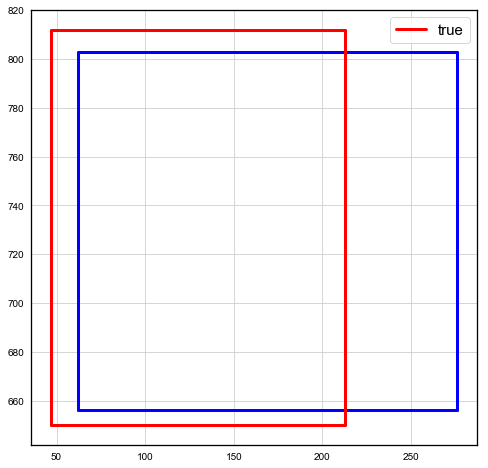

In [20]:
k = 0
print('iou_metric:', iou_metric([dat.Xmin[k], dat.Xmax[k], dat.Ymin[k], dat.Ymax[k]], 
                 [dat.Xmin_true[k], dat.Xmax_true[k], dat.Ymin_true[k], dat.Ymax_true[k]]))
plot_rectangle([dat.Xmin[k], dat.Xmax[k], dat.Ymin[k], dat.Ymax[k]])
plot_rectangle([dat.Xmin_true[k], dat.Xmax_true[k], dat.Ymin_true[k], dat.Ymax_true[k]], color='red', label='true')

---
### EDA
---

Посмотрим на распределение числа уникальных значений userId

In [417]:
pd.Series(dat.userId[tr_indexes].value_counts().values).describe()

count    1357.000000
mean        3.932940
std         5.549515
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        79.000000
dtype: float64

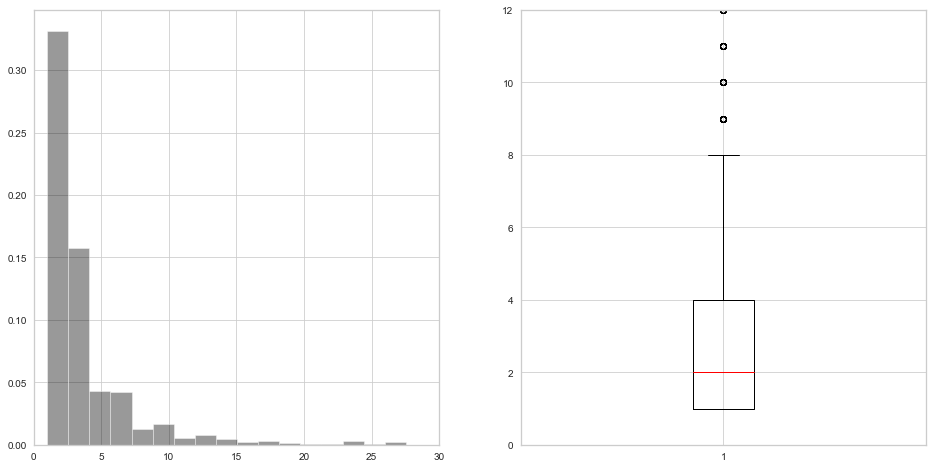

In [418]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
sns.distplot(dat.userId[tr_indexes].value_counts().values, kde=False, norm_hist=True, ax=ax[0])
ax[0].set_xlim(0, 30);
ax[1].boxplot(dat.userId[tr_indexes].value_counts().values);
plt.ylim(0, 12);

Есть ли новые юзеры в тесте

In [185]:
new_users = np.array(list(set(dat.userId[te_indexes]).difference(dat.userId[tr_indexes])))
print('В тесте всего {} уникальных юзеров, из них {} ({}%) не было в треине'.format(dat.userId[te_indexes].value_counts().shape[0], 
                                                                                    new_users.shape[0], 
                                                                                    100*np.round(new_users.shape[0]/dat.userId[te_indexes].value_counts().shape[0], decimals=2)))

В тесте всего 1192 уникальных юзеров, из них 191 (16.0%) не было в треине


Есть ли картинке в тесте, которые были в треине

In [191]:
print('В тесте {} картинок, которые были в треине'.format(len(set(dat.itemId[te_indexes]).intersection(set(dat.itemId[tr_indexes])))))

В тесте 0 картинок, которые были в треине


Посмотрим на распределение числа раз, когда юзер размечал картинку

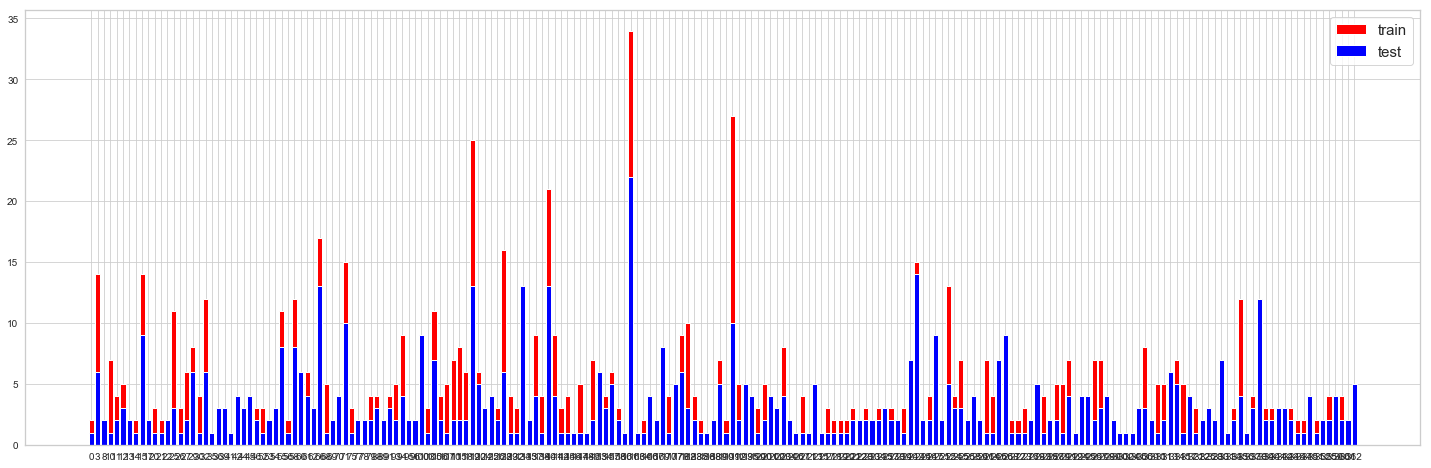

In [269]:
userid_interect = np.array(list(set(dat.userId[tr_indexes]).intersection(set(dat.userId[te_indexes]))))
tr_dict = dict(zip(userid_interect, [0 for i in userid_interect]))
te_dict = dict(zip(userid_interect, [0 for i in userid_interect]))
for user_id in tqdm_notebook(userid_interect):
    tr_dict[user_id] += (dat.userId[tr_indexes] == user_id).sum()
    te_dict[user_id] += (dat.userId[te_indexes] == user_id).sum()
tr_vals = list(tr_dict.values())
te_vals = list(te_dict.values())
plt.figure(figsize=(25, 8))
k = 200
plt.bar(np.arange(userid_interect.shape[0])[:k], tr_vals[:k], color='red', label='train')
plt.xticks(np.arange(userid_interect.shape[0])[:k], userid_interect[:k]);
plt.bar(np.arange(userid_interect.shape[0])[:k], te_vals[:k], color='blue', label='test')
plt.xticks(np.arange(userid_interect.shape[0])[:k], userid_interect[:k]);
plt.legend(fontsize=15);

Та же тенденция в scatterplot

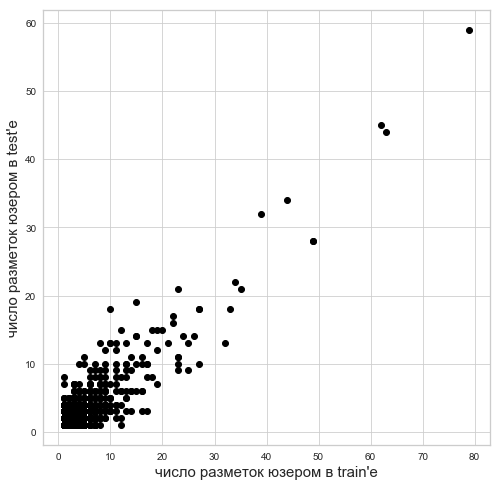

In [271]:
plt.scatter(tr_vals, te_vals);
plt.xlabel("число разметок юзером в train'e", fontsize=15);
plt.ylabel("число разметок юзером в test'e", fontsize=15);

Можно сделать вывод, что выборка разделена на треин и тест случайно

Построим матрицу, описывающую сколько юзеров разметило сколько картинок

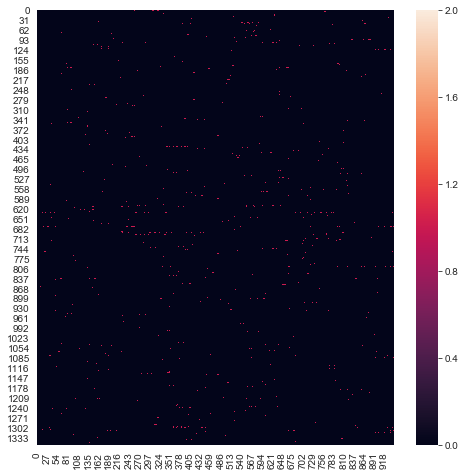

In [172]:
sns.heatmap(pd.crosstab(dat.userId[tr_indexes], dat.itemId[tr_indexes]).values);

Посмотрим на распеределение истинных координат точек, в зависимоти от размеченных координат

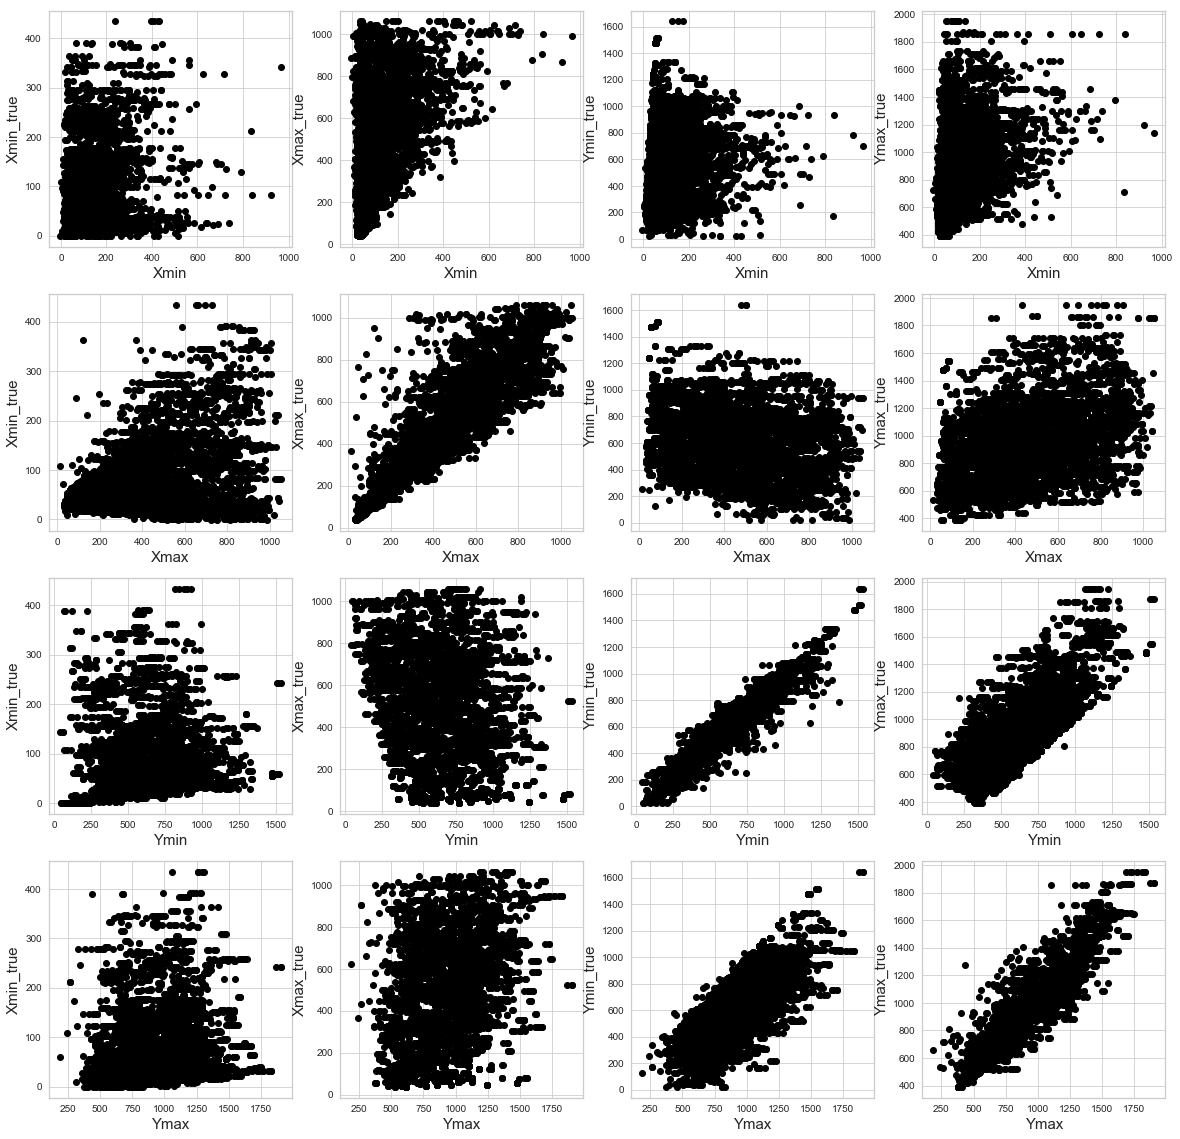

In [324]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
j = list(itertools.product([0, 1, 2, 3], [0, 1, 2, 3]))
k = 0
for taged_pos, true_pos in itertools.product(['Xmin', 'Xmax', 'Ymin', 'Ymax'], ['Xmin_true', 'Xmax_true', 'Ymin_true', 'Ymax_true']):
    ax[j[k][0], j[k][1]].scatter(dat[taged_pos][tr_indexes], dat[true_pos][tr_indexes])
    ax[j[k][0], j[k][1]].set_xlabel(taged_pos, fontsize=15);
    ax[j[k][0], j[k][1]].set_ylabel(true_pos, fontsize=15);
    k += 1

Эту зависимость можно так же изобразить в виде корреляционной матрицы

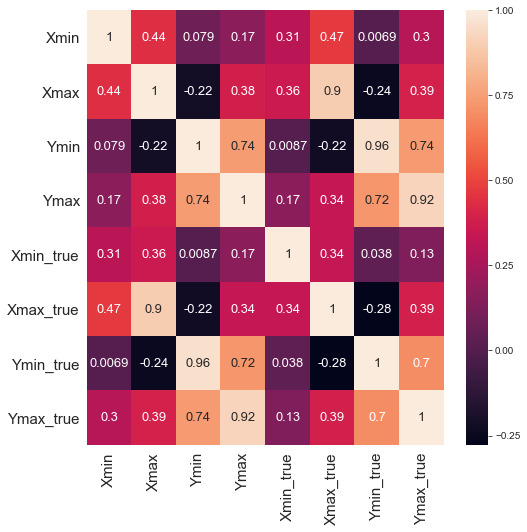

In [334]:
sns.heatmap(dat.loc[tr_indexes, ['Xmin', 'Xmax', 'Ymin', 'Ymax', 'Xmin_true', 'Xmax_true', 'Ymin_true', 'Ymax_true']].corr(), 
            annot=True, annot_kws={'size': 13});
plt.xticks(fontsize=15, rotation=90);
plt.yticks(fontsize=15, rotation=0);

Посмотрим на распределение истинных и размеченных координат

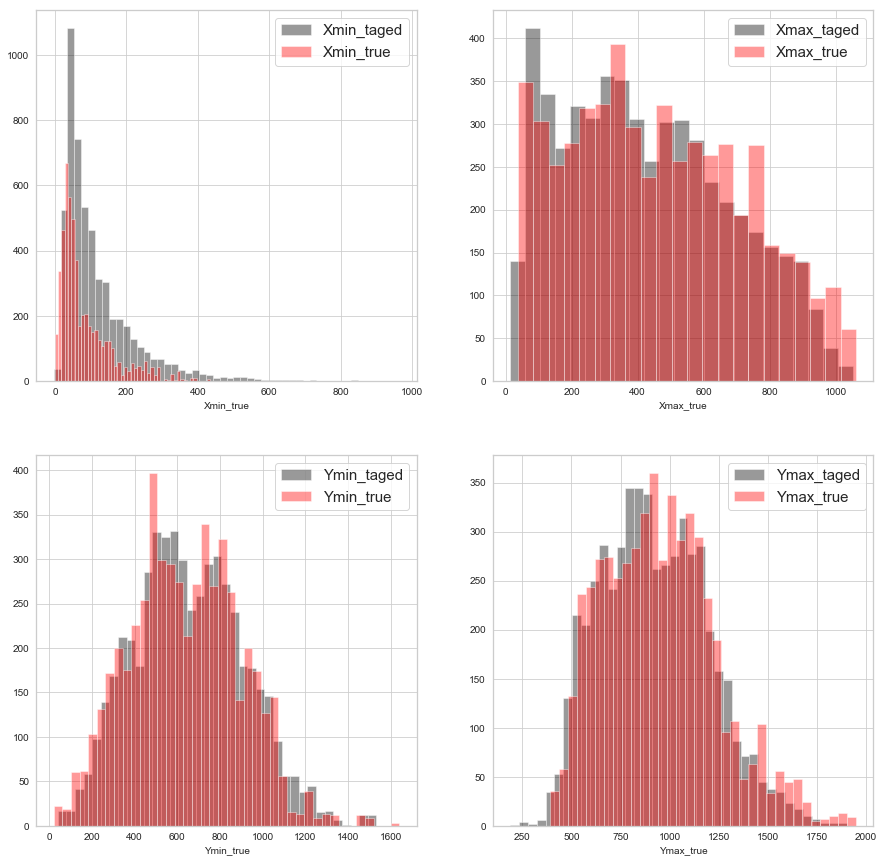

In [367]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 15));
sns.distplot(dat.Xmin[tr_indexes], kde=False, ax=ax[0, 0], label='Xmin_taged');
sns.distplot(dat.Xmin_true[tr_indexes], kde=False, ax=ax[0, 0], label='Xmin_true');
ax[0, 0].legend(fontsize=15);

sns.distplot(dat.Xmax[tr_indexes], kde=False, ax=ax[0, 1], label='Xmax_taged');
sns.distplot(dat.Xmax_true[tr_indexes], kde=False, ax=ax[0, 1], label='Xmax_true');
ax[0, 1].legend(fontsize=15);

sns.distplot(dat.Ymin[tr_indexes], kde=False, ax=ax[1, 0], label='Ymin_taged');
sns.distplot(dat.Ymin_true[tr_indexes], kde=False, ax=ax[1, 0], label='Ymin_true');
ax[1, 0].legend(fontsize=15);

sns.distplot(dat.Ymax[tr_indexes], kde=False, ax=ax[1, 1], label='Ymax_taged');
sns.distplot(dat.Ymax_true[tr_indexes], kde=False, ax=ax[1, 1], label='Ymax_true');
ax[1, 1].legend(fontsize=15);

Посмотрим на пример разметок для одной картинки

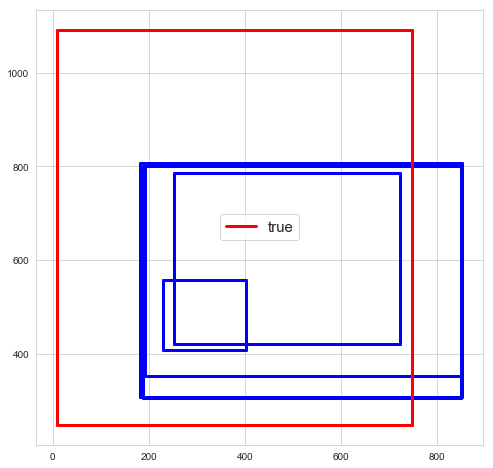

In [26]:
k = 6
current_df = dat.loc[dat.itemId == dat.itemId[tr_indexes].value_counts().keys()[k]]
for i in range(5):
    plot_rectangle(current_df[['Xmin', 'Xmax', 'Ymin', 'Ymax']].values[i])
plot_rectangle(current_df[['Xmin_true', 'Xmax_true', 'Ymin_true', 'Ymax_true']].values[0], label='true', color='red');


Посмотрим на распределение метрики по юзерам (нужна переменная iou: см. Генерация признаков)

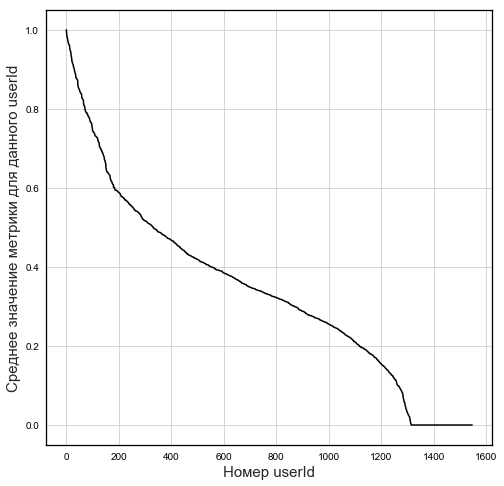

In [55]:
plt.plot(dat.groupby(['userId'])['iou'].mean().sort_values(ascending=False).values)
plt.xlabel('Номер userId', fontsize=15);
plt.ylabel('Среднее значение метрики для данного userId', fontsize=15);

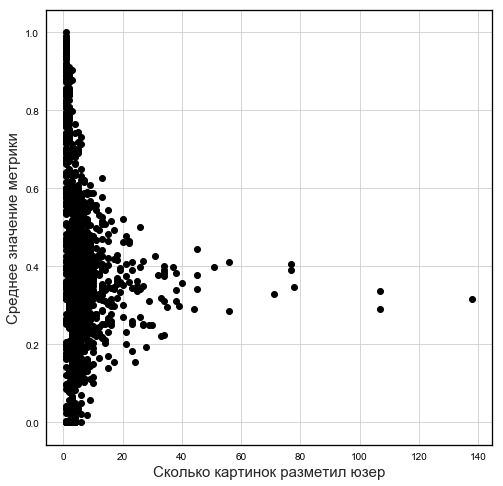

In [47]:
a = dat.groupby(['userId'])['userId_ntimes', 'iou'].mean()
plt.scatter(a.userId_ntimes, a.iou);
plt.xlabel('Сколько картинок разметил юзер', fontsize=15);
plt.ylabel('Среднее значение метрики', fontsize=15);

---
### Генерация признаков
---

Подсчитаем метрику для треиновых объектов

In [21]:
dat['iou'] = 0
metric_ = []
for i in tqdm_notebook(range(len(tr_indexes))):
    metric_.append(iou_metric([dat.Xmin[tr_indexes[i]], dat.Xmax[tr_indexes[i]], dat.Ymin[tr_indexes[i]], dat.Ymax[tr_indexes[i]]], 
                                        [dat.Xmin_true[tr_indexes[i]], dat.Xmax_true[tr_indexes[i]], dat.Ymin_true[tr_indexes[i]], 
                                         dat.Ymax_true[tr_indexes[i]]]))
dat.iou[tr_indexes] = metric_

C:\Users\anton.andreytsev\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


Добавим для каждого уникального userId число раз, сколько юзер картинок разметил в треине

In [22]:
dat['userId_ntimes'] = dat.userId.map(dict(dat.userId.value_counts()))

Добавим для каждого юзера разницу его разметки - истинная координата

In [23]:
for col in target_cols:
    dat[col.replace('_true', '') + '_minus_' + col] = dat[col.replace('_true', '')] - dat[col]

---
### Модели
---

In [141]:
from sklearn.base import BaseEstimator 
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

class MlBootcampRegressor(BaseEstimator):
    
    def __init__(self, regressor_model=CatBoostRegressor):
        self.regressor_model = regressor_model
        self.trained_models = None
        self.features_columns = None
        self.target_columns = None
        self.validation_score = None
        
    def fit(self, X_y, features_columns, target_columns=['Xmin_true', 'Ymin_true', 'Xmax_true', 'Ymax_true'], model_parameters=None, 
            n_folds=None):
        self.features_columns = features_columns
        self.target_columns = target_columns
        if model_parameters is not None:
            local_model = self.regressor_model(**model_parameters)
        else:
            local_model = self.regressor_model
            
        if n_folds is not None:
            self.trained_models = []
            self.validation_score = []
            predicts = [] 
            true_targets = []
            for fold in tqdm_notebook(range(n_folds)):
                dat_val, dat_test = train_test_split(X_y, test_size=0.25, shuffle=True)
                current_col_predicitons = []
                current_col_targets = []
                self.trained_models.append({})
                for col in tqdm_notebook(target_cols):
                    local_model.fit(dat_val[features_columns].values, dat_val[col].values)
                    self.trained_models[-1].update({col: local_model})
                    for item_id in set(dat_test.itemId):
                        current_col_predicitons.append(self.trained_models[-1][col].predict(dat_test.loc[dat_test.itemId == item_id, 
                                                                                                         self.features_columns].values).mean())
                        current_col_targets.append(dat_test[col][dat_test.itemId == item_id].values.mean())
                true_targets.append(current_col_targets)
                predicts.append(current_col_predicitons)
                
                current_fold_metric = []
                for i in range(len(predicts)):
                    current_fold_metric.append(iou_metric(predicts[i], true_target[i]))
                self.validation_score.append(np.mean(current_fold_metric))
        else:
            self.trained_models = {}
            for col in tqdm_notebook(target_columns):
                local_model.fit(X_y[features_columns].values, X_y[col].values)
                self.trained_models.update({col: local_model})
                    
    def predict(self, X, item_ids_column):
        predictions = []
        for item_id in tqdm_notebook(item_ids_column):
            current_col_predicitons = []
            for col in self.target_columns:
                current_col_predicitons.append(self.trained_models[col].predict(X.loc[X.itemId == item_id, self.features_columns].values).mean())
            predictions.append(current_col_predicitons)
        return np.array(predictions)
    

In [ ]:
model = MlBootcampRegressor()
model.fit(X_y=dat.loc[tr_indexes], features_columns=['userId', 'Xmin', 'Ymin', 'Xmax', 'Ymax', 'iou', 'userId_ntimes',
       'Xmin_minus_Xmin_true', 'Ymin_minus_Ymin_true', 'Xmax_minus_Xmax_true',
       'Ymax_minus_Ymax_true'], target_columns=['Xmin_true',
       'Ymin_true', 'Xmax_true', 'Ymax_true'], model_parameters={'verbose': False}, n_folds=5)

In [128]:
preds = model.predict(dat.loc[tr_indexes], item_ids_column=set(dat.itemId[tr_indexes]))

In [61]:
cat_dict = {}
for col in tqdm_notebook(target_cols):
    cat = CatBoostRegressor()
    cat.fit(dat.loc[tr_indexes, ['userId', 'Xmin', 'Ymin', 'Xmax', 'Ymax']].values, 
            dat[col][tr_indexes].values, verbose=False, cat_features=[0])
    cat_dict.update({'cat_' + col.replace('_true', ''): cat})

In [156]:
from sklearn.model_selection import train_test_split
for fold in tqdm_notebook(range(5)):
    dat_val, dat_test = train_test_split(dat.loc[tr_indexes], test_size=0.2, shuffle=True)
    cat_dict = {}
    for col in tqdm_notebook(target_cols):
        cat = CatBoostRegressor()
        cat.fit(dat_val[['userId', 'Xmin', 'Ymin', 'Xmax', 'Ymax']], 
                dat_val[col], verbose=False, cat_features=[0])
        cat_dict.update({'cat_' + col.replace('_true', ''): cat})
#     predictions = 

KeyboardInterrupt: 

---
### Получение предсказаний для теста и сохранение ответа
---

In [139]:
submit = pd.read_csv(os.path.join(FILE_PATH, 'sample_submit_zero.csv'), header=None)
submit.shape

(630, 5)

In [141]:
for i, itemid in tqdm_notebook(enumerate(submit[0])):
    submit.iloc[i, 1] = cat_dict['cat_Xmin'].predict(dat.loc[dat.itemId == itemid, ['userId', 'Xmin', 'Ymin', 'Xmax', 'Ymax']]).mean()
    submit.iloc[i, 2] = cat_dict['cat_Ymin'].predict(dat.loc[dat.itemId == itemid, ['userId', 'Xmin', 'Ymin', 'Xmax', 'Ymax']]).mean()
    submit.iloc[i, 3] = cat_dict['cat_Xmax'].predict(dat.loc[dat.itemId == itemid, ['userId', 'Xmin', 'Ymin', 'Xmax', 'Ymax']]).mean()
    submit.iloc[i, 4] = cat_dict['cat_Ymax'].predict(dat.loc[dat.itemId == itemid, ['userId', 'Xmin', 'Ymin', 'Xmax', 'Ymax']]).mean()


In [145]:
submit.to_csv('/Users/tony/Desktop/ml_boot1.csv', index=False, header=False)